In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
import random
from math import sin, cos, sqrt, atan2, radians
from ease_grid import EASE2_grid
grid_size = 36000
egrid = EASE2_grid(grid_size)
assert egrid.shape == (406, 964)
from impacts import IMPAaCS
from impacts import distance

In [2]:
impact_boundz=20
[-impact_boundz, impact_boundz]
I = IMPAaCS(egrid, max_depth_of_impact_melt=330, 
               lon_lims = [-impact_boundz, impact_boundz], lat_lims = [-impact_boundz, impact_boundz])
new_lat=[]
new_lon=[]
for i in I.lon_subset:
    if np.abs(i)<20:
        new_lon.append(i)
for i in I.lat_subset:
    if np.abs(i)<20:
        new_lat.append(i)
I.lon_subset = new_lon
I.lat_subset = new_lat
I.n_x = len(I.lon_subset)
I.n_y = len(I.lat_subset)

plotting SiO2  map for layers [0], and distribution for layer 0


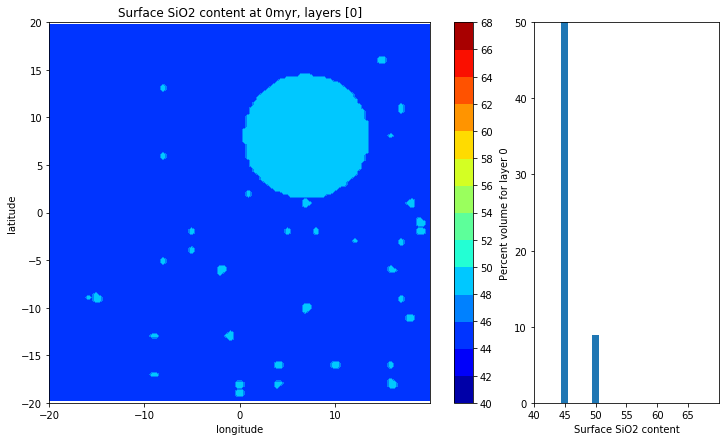

plotting SiO2  map for layers [1], and distribution for layer 1


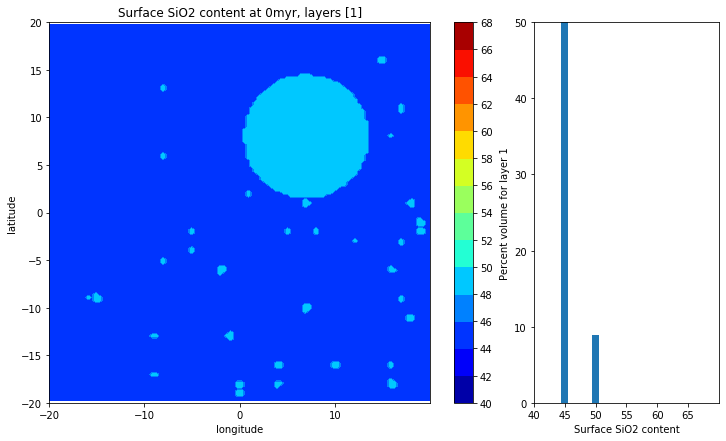

plotting SiO2  map for layers [2], and distribution for layer 2


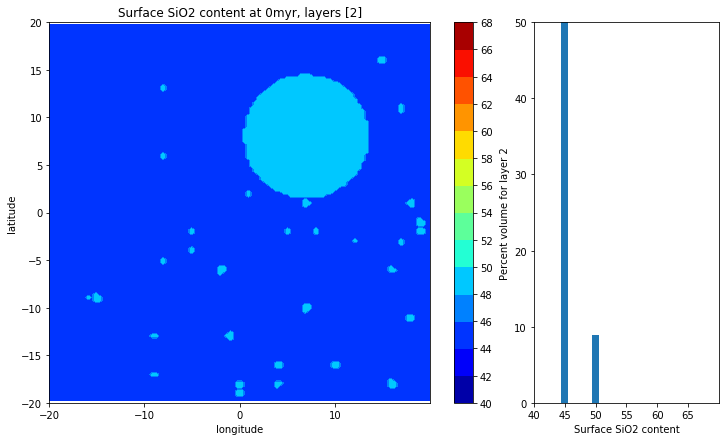

plotting SiO2  map for layers [3], and distribution for layer 3


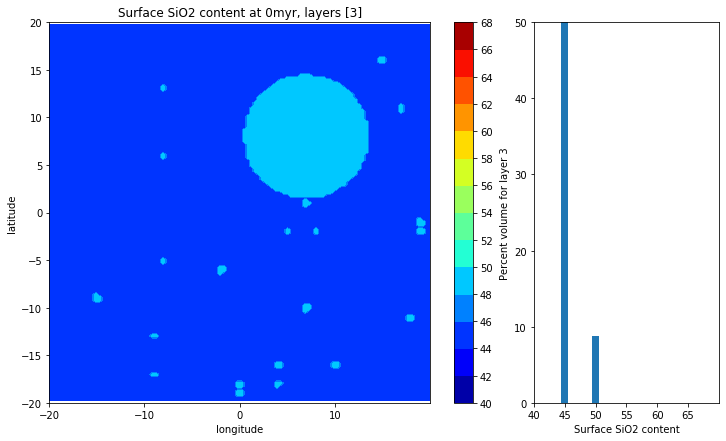

------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


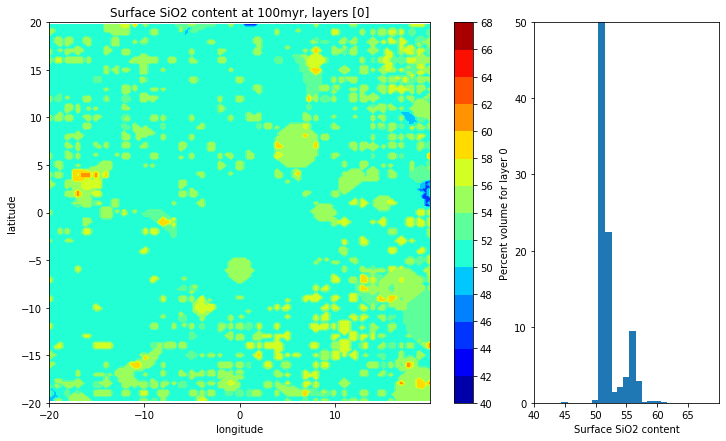

plotting SiO2  map for layers [1], and distribution for layer 1


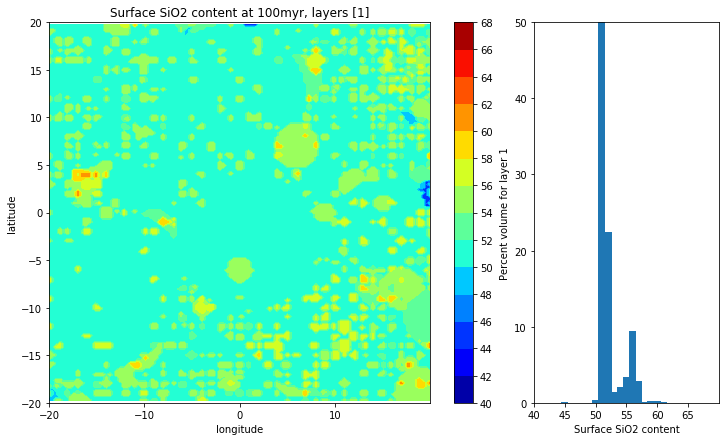

plotting SiO2  map for layers [2], and distribution for layer 2


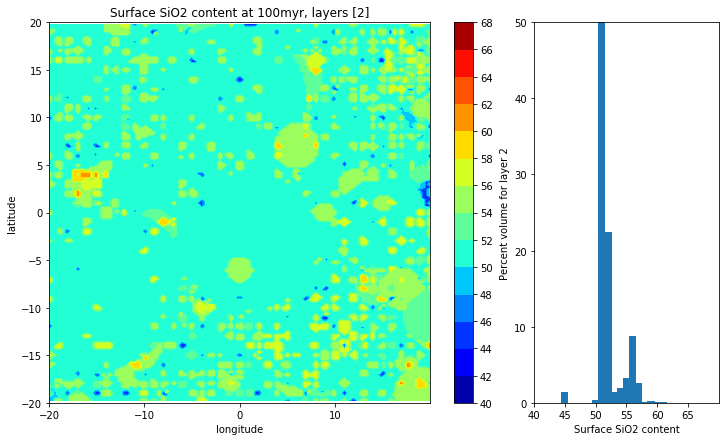

plotting SiO2  map for layers [3], and distribution for layer 3


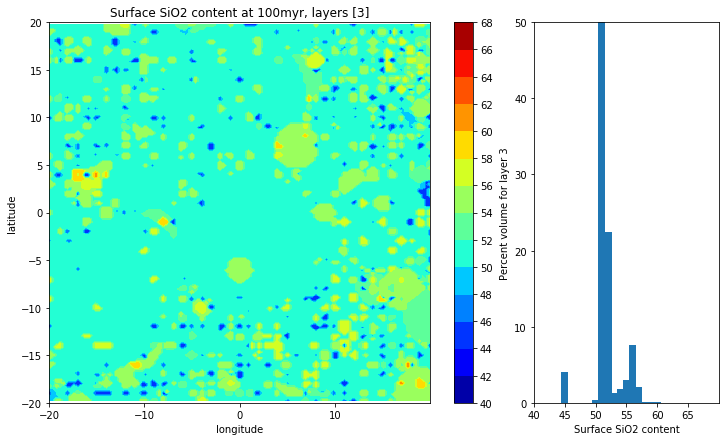

------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


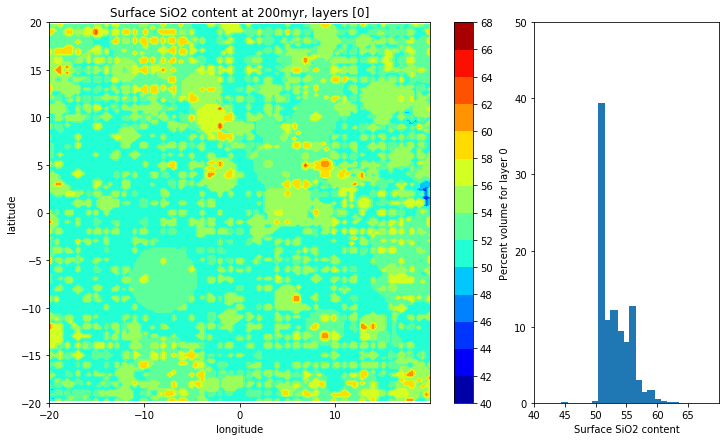

plotting SiO2  map for layers [1], and distribution for layer 1


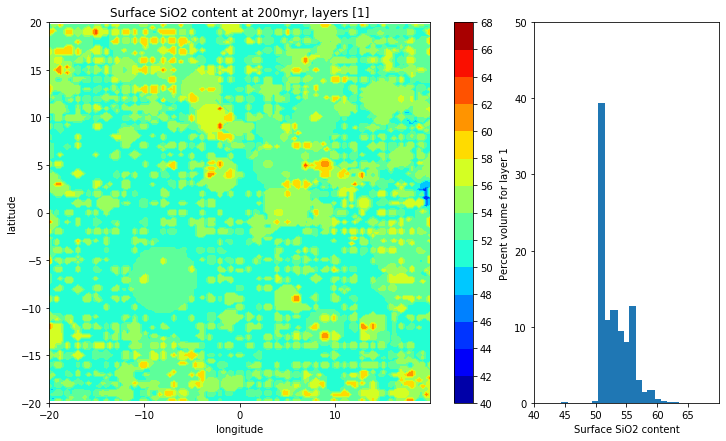

plotting SiO2  map for layers [2], and distribution for layer 2


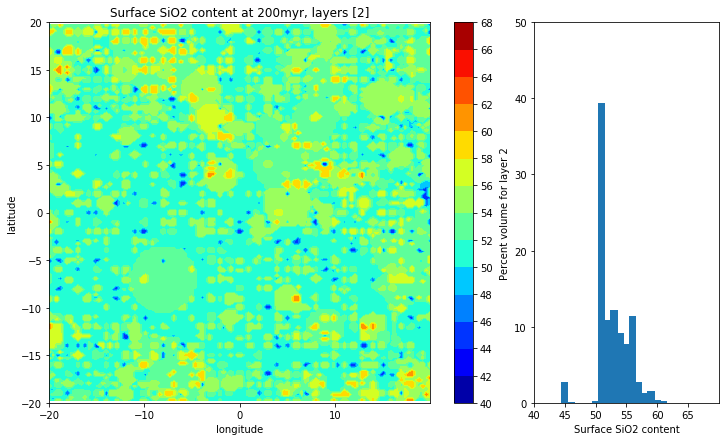

plotting SiO2  map for layers [3], and distribution for layer 3


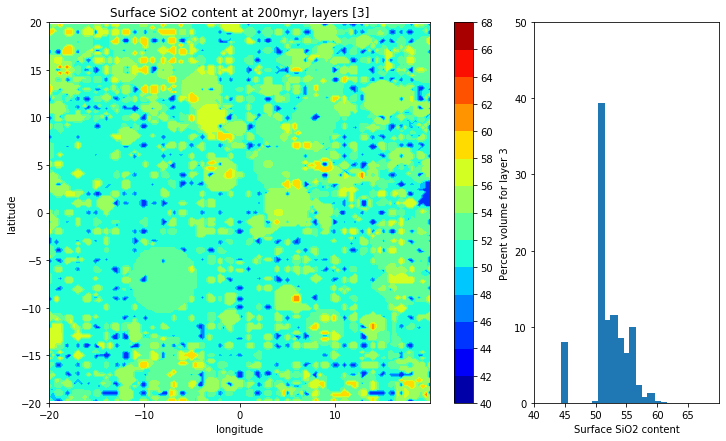

------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------


In [3]:

for t in [0,100,200]:
    state_file = './impact_states/march2022_5/0/{}.pkl'.format(t)
    with open(state_file, 'rb') as fb:
        impact_states = pkl.load(fb)
    I.grid_cell_state = impact_states
    I.sim_time=t*1000000
    I.do_volume_by_layer(n_layers=4)
    I.plot_map_and_bar(save_figure=False, plot_figure=True, map_layers=[0], dist_layer=0)
    I.plot_map_and_bar(save_figure=False, plot_figure=True, map_layers=[1], dist_layer=1)
    I.plot_map_and_bar(save_figure=False, plot_figure=True, map_layers=[2], dist_layer=2)
    I.plot_map_and_bar(save_figure=False, plot_figure=True, map_layers=[3], dist_layer=3)
    print("------------------------------------------------------------------------")
    print("------------------------------------------------------------------------")
    print("------------------------------------------------------------------------")
    print("------------------------------------------------------------------------")

plotting SiO2  map for layers [0], and distribution for layer 0


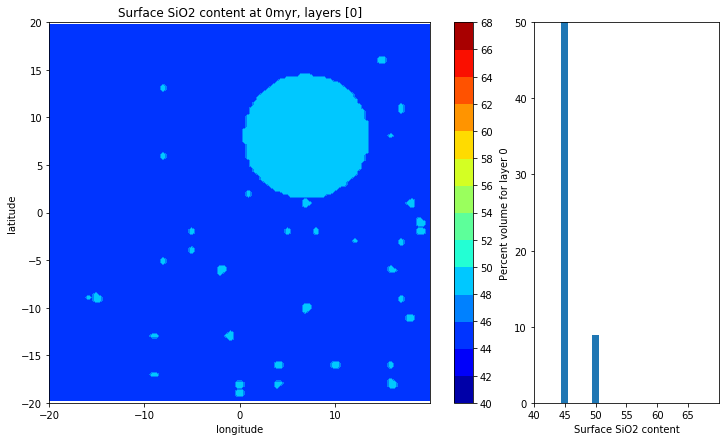

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


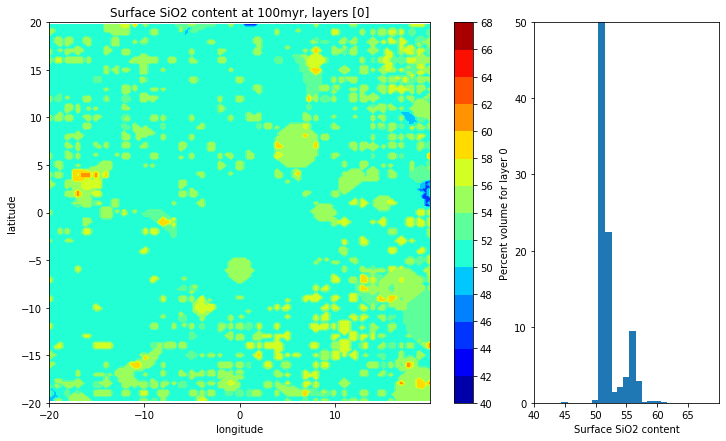

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


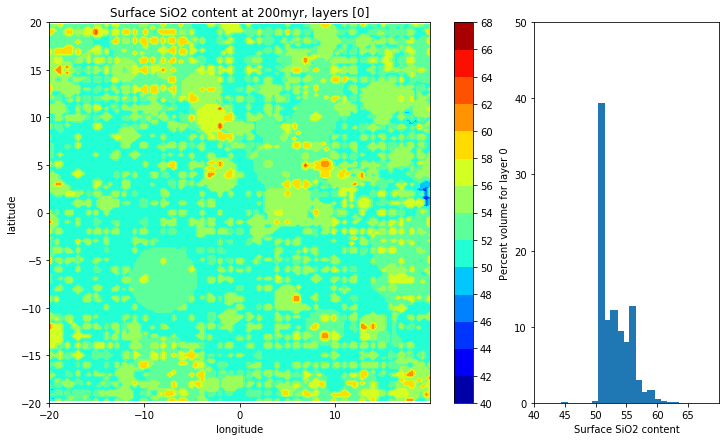

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


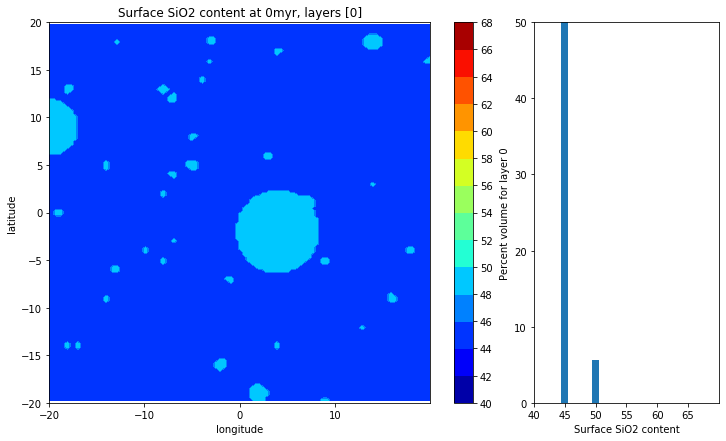

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


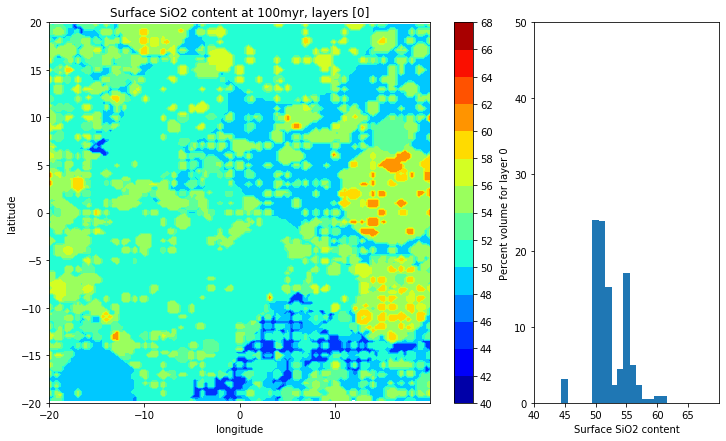

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


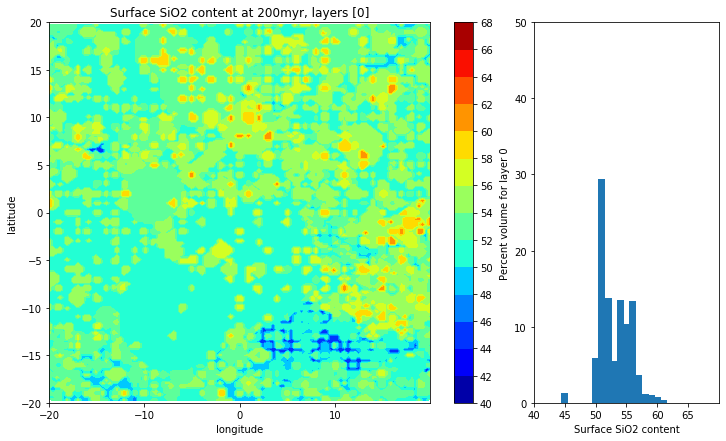

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


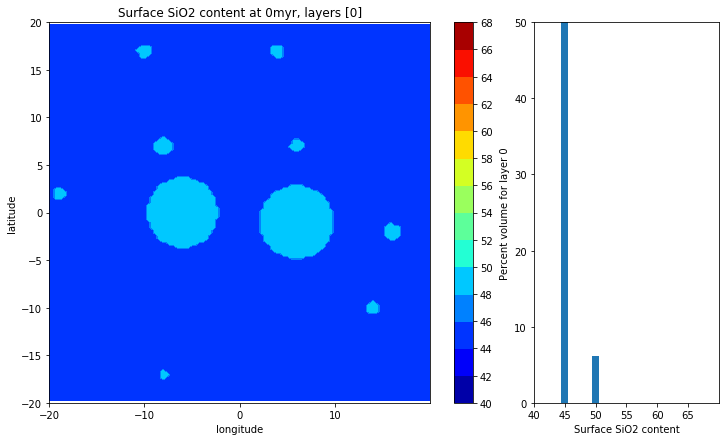

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


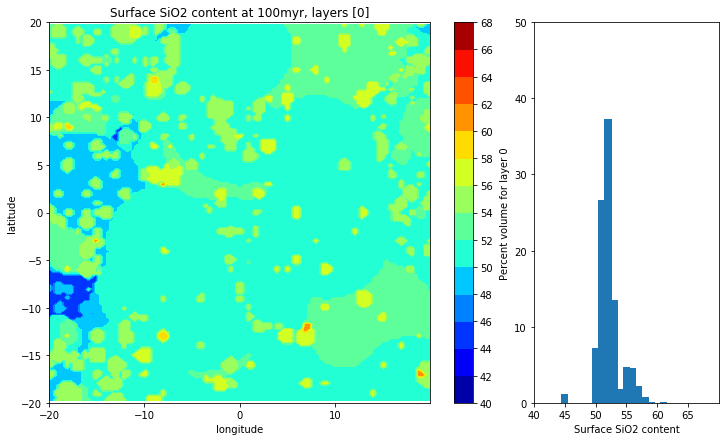

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


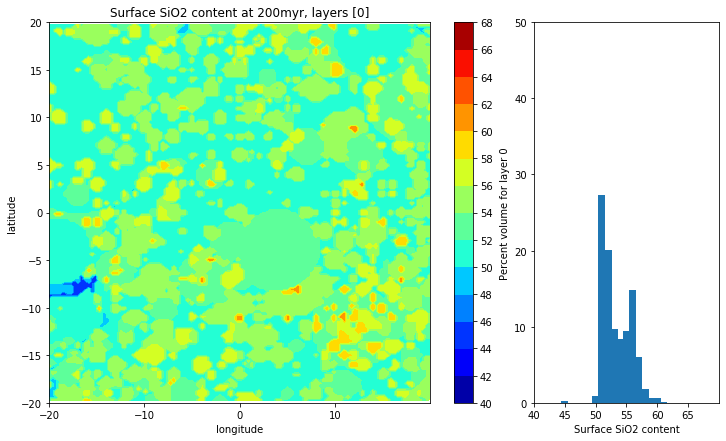

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


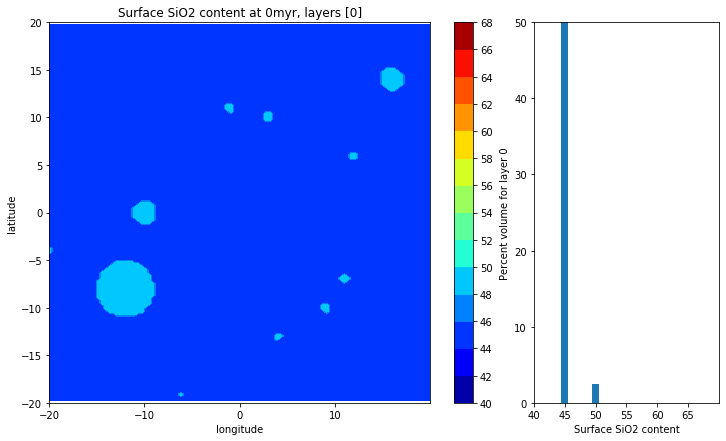

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


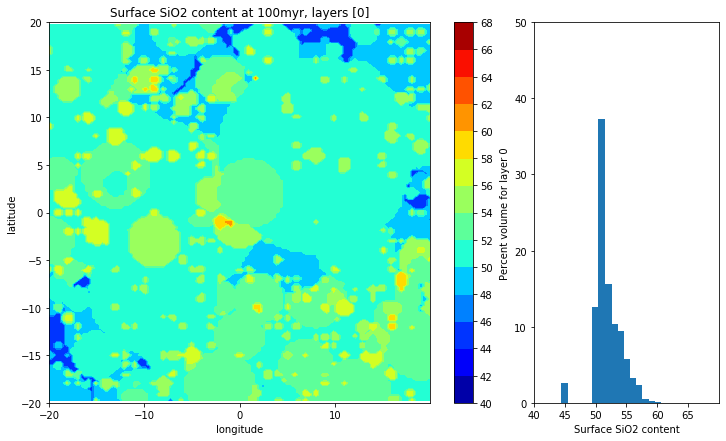

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


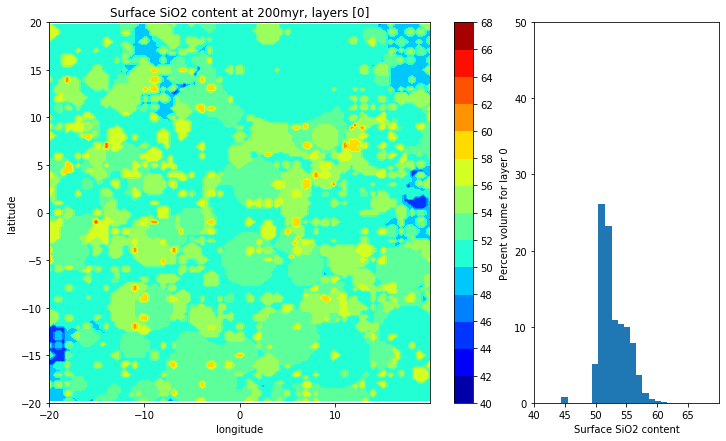

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


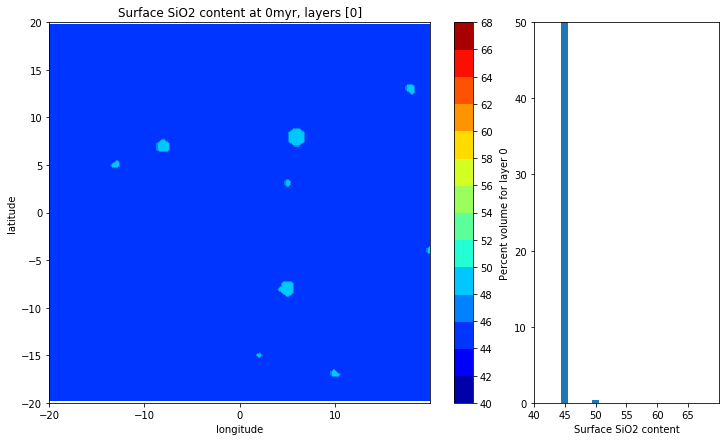

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


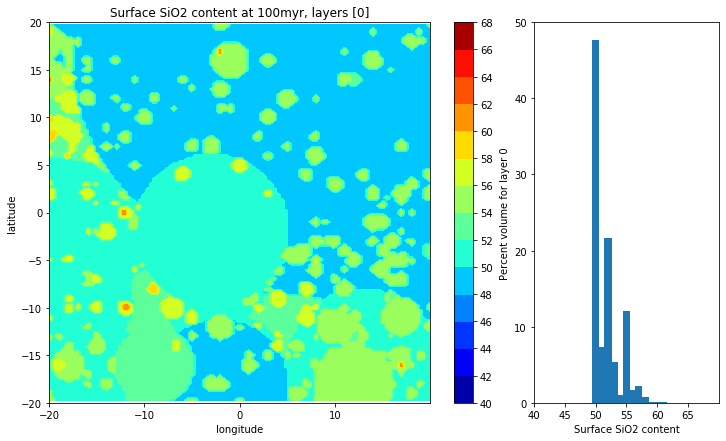

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


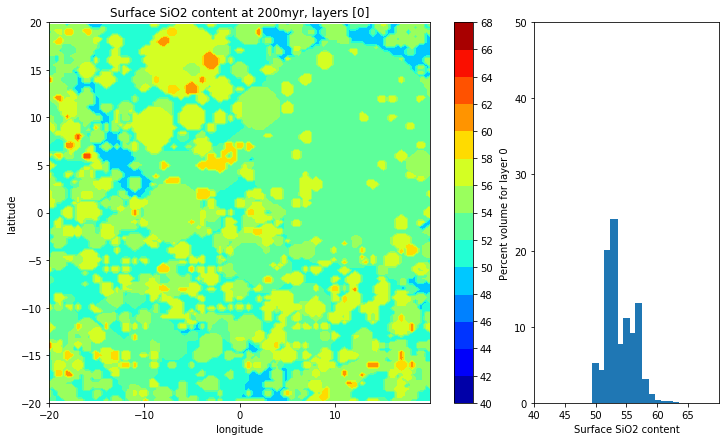

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


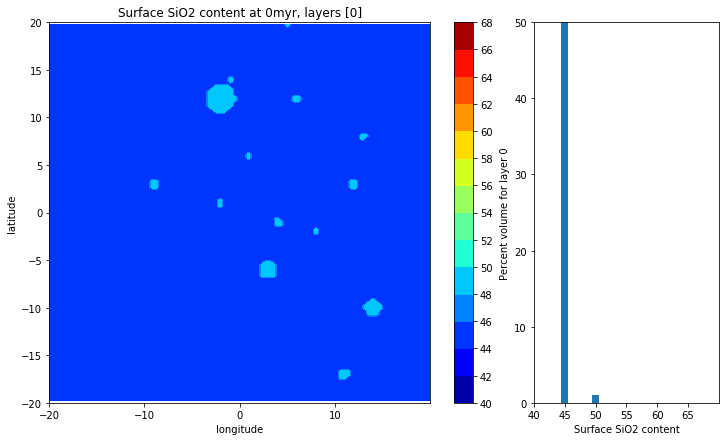

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


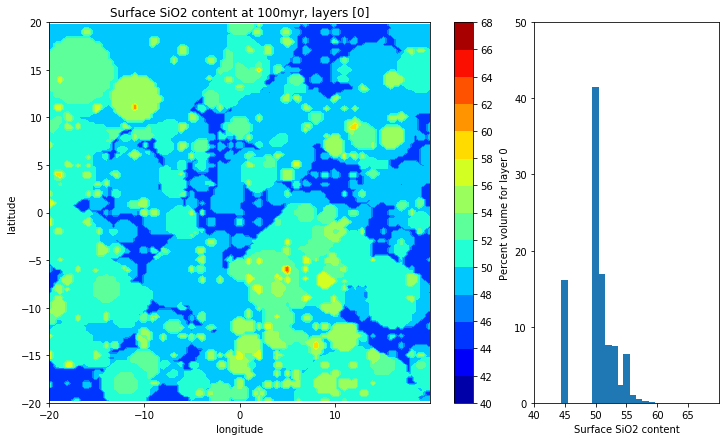

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


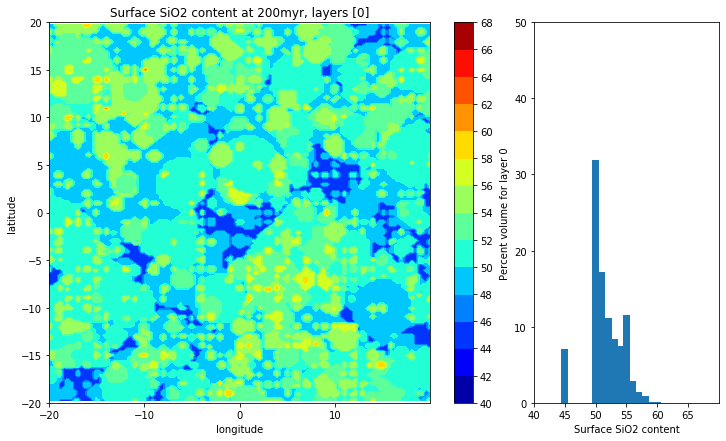

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


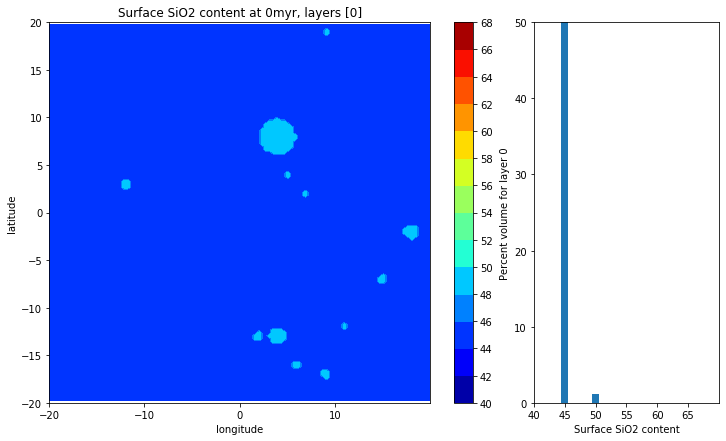

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


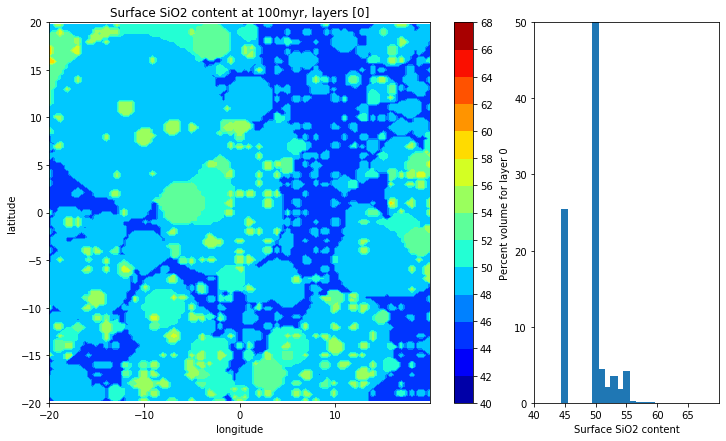

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


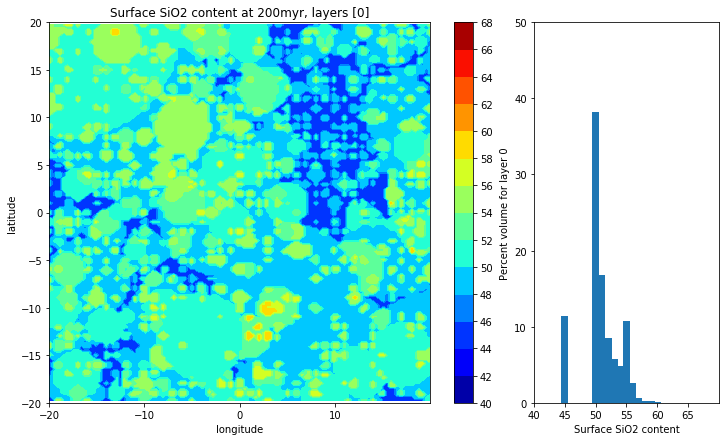

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


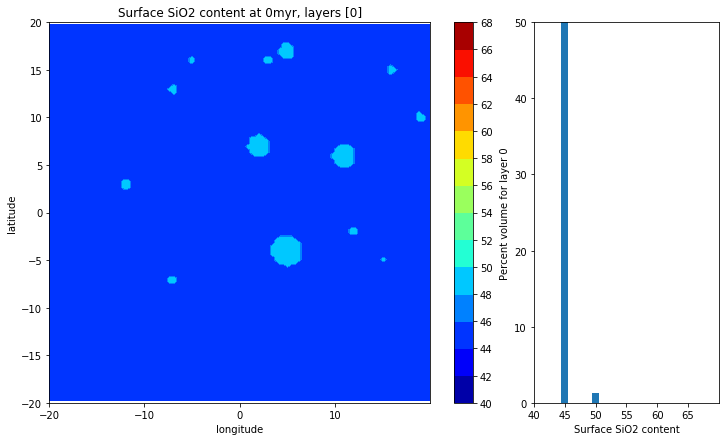

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


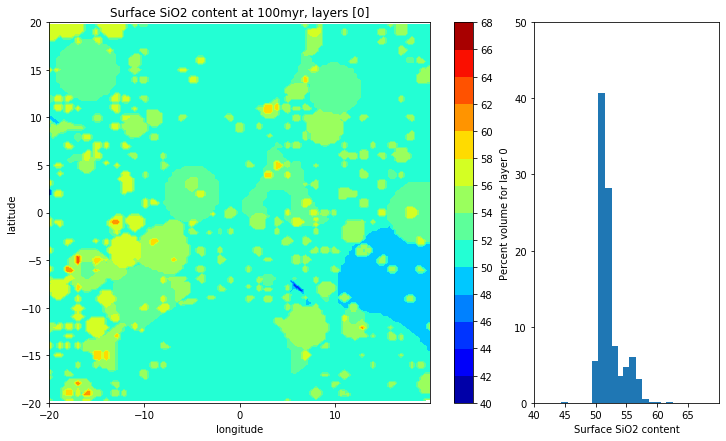

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


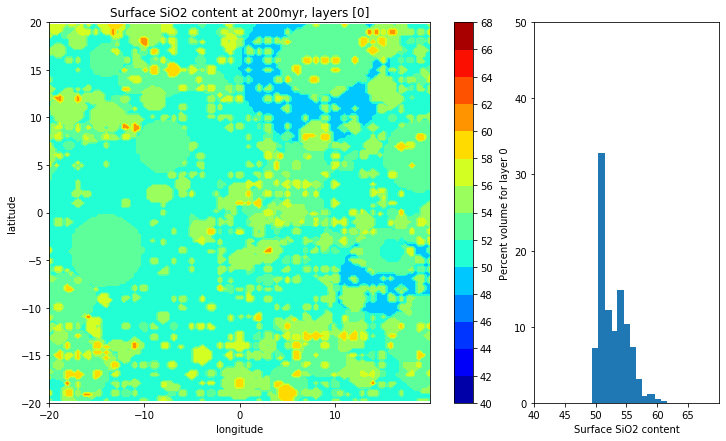

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


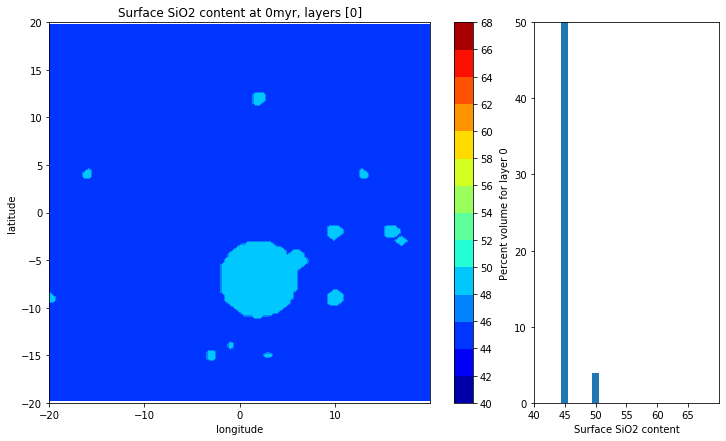

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


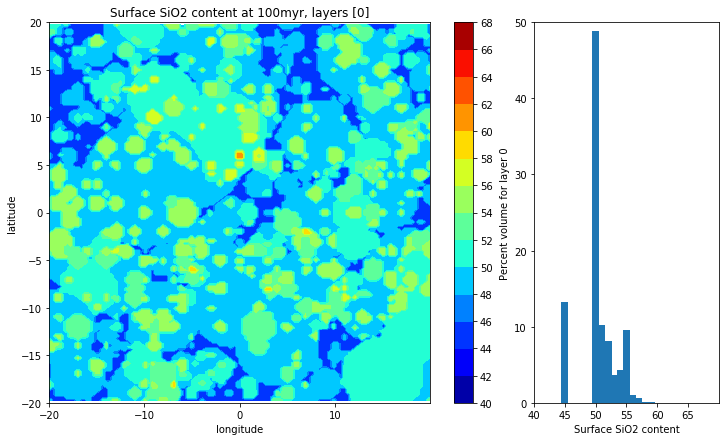

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


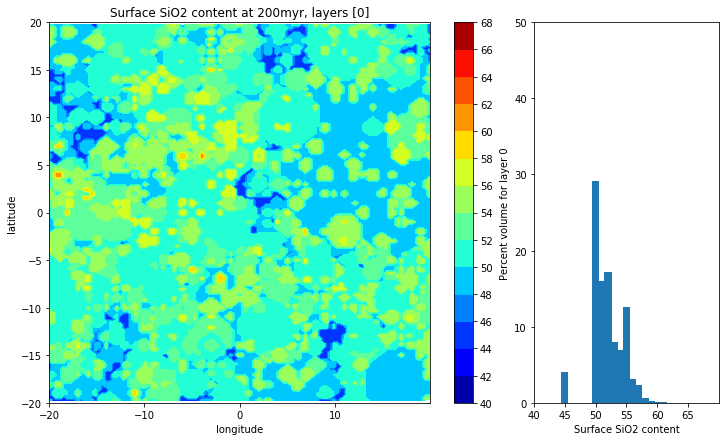

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


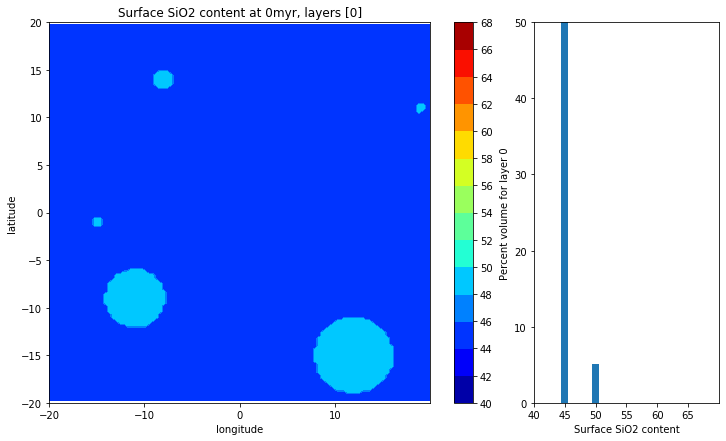

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


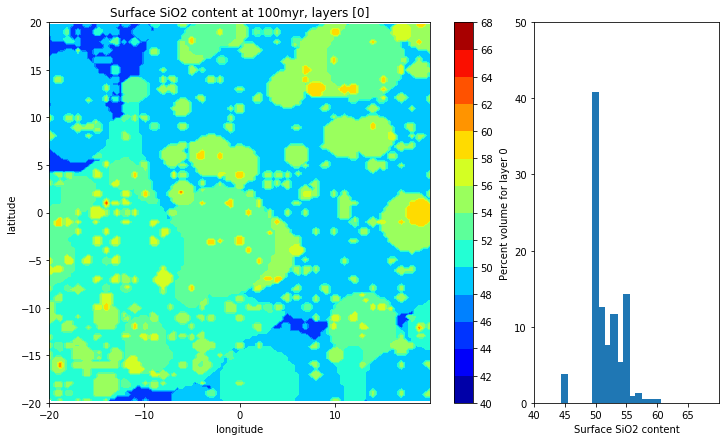

------------------------------------------------------------------------
plotting SiO2  map for layers [0], and distribution for layer 0


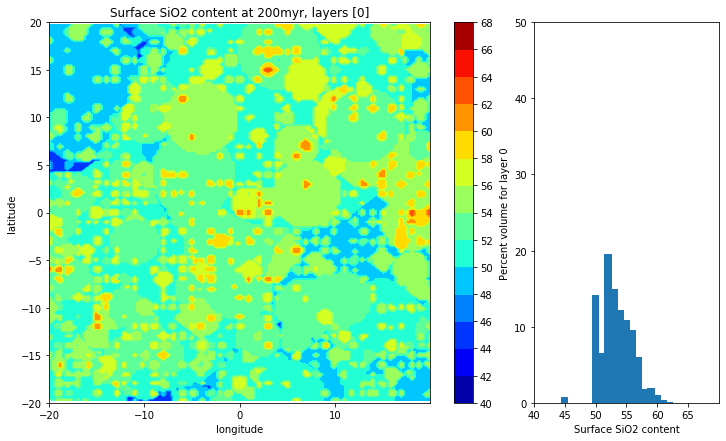

------------------------------------------------------------------------


In [4]:

for ensemble_member in range(10):
    for t in [0,100,200]:
        state_file = f'./impact_states/march2022_5/{ensemble_member}/{t}.pkl'
        with open(state_file, 'rb') as fb:
            impact_states = pkl.load(fb)
        I.grid_cell_state = impact_states
        I.sim_time=t*1000000
        I.do_volume_by_layer(n_layers=4)
        I.plot_map_and_bar(save_figure=False, plot_figure=True, map_layers=[0], dist_layer=0)
        print("------------------------------------------------------------------------")

In [5]:
# I = IMPAaCS(egrid)
# for t in range(452,500,1):
#     state_file = './impact_states/impacts_E1_t{:d}.pkl'.format(t)
#     with open(state_file, 'rb') as fb:
#         impact_states = pkl.load(fb)
#     impact_states[list(impact_states.keys())[0]][:] = 35
#     impact_states[list(impact_states.keys())[1]][:] = 70
#     I.grid_cell_state = impact_states
#     I.sim_time=t*1000000
# #    I.plot_map(save_figure=True, plot_figure=True)    
#     I.plot_map_and_bar(save_figure=True, plot_figure=False, fig_path = "./figures/directory/")
